<font size="+3"><strong>Polish Bankruptcy Prediction 🇵🇱 </strong></font>

<font size="+2"><strong>Part 2: Imbalanced Data</strong></font>

In [1]:
__author__ = "Donald Ghazi"
__email__ = "donald@donaldghazi.com"
__website__ = "donaldghazi.com"

In the `Working with JSON files` project, I prepared the data. 

In this project, I'm going to explore some of the features of the dataset, use visualizations to help me understand those features, and develop a model that solves the problem of imbalanced data by under- and over-sampling.

In [2]:
import gzip
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

GOALS
 - Identify imbalanced data and address it with resampling.
 - Build a model to predict bankruptcy.
 - Evaluate model predictions using a confusion matrix.
 - Save my model as a file.

Machine Learning Workflow
 - Prepare Data
     - Import
     - Explore: Class imbalance
         - Positive class, negative class;skew
     - Split
     - Resample: Under-and over-sampling
 - Build Model
     - Baseline: High accuracy score
     - Iterate: Four models
     - Evaluate: Confusion matrix
 - Communicate Results
     - Feature Importances
     - Save model as file
         - Binary mode

# Prepare Data

## Import

I will begin by bringing my data into the project, and the function I developed in the `Working with JSON files` project is exactly what I need. 

**Wrangle Function**

In [3]:
# Write rangle function using the code I developed in the "Working with JSON files" project
def wrangle(filename):
    
    # Open compressed file, load into dictionary
    with gzip.open(filename, "r") as f:
        data = json.load(f)

    # Load dictionary into DataFrame, set index
    df = pd.DataFrame().from_dict(data["data"]).set_index("company_id")

    return df

In [4]:
# Import poland-bankruptcy-data-2009.json.gz into the DataFrame df
df = wrangle("data/poland-bankruptcy-data-2009.json.gz")
print(df.shape)
df.head()

(9977, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


## Explore

**Inspect Data**

I can use the `info`  method to explore `df`.

In [5]:
# Inspect DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9977 entries, 1 to 10503
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feat_1    9977 non-null   float64
 1   feat_2    9977 non-null   float64
 2   feat_3    9977 non-null   float64
 3   feat_4    9960 non-null   float64
 4   feat_5    9952 non-null   float64
 5   feat_6    9977 non-null   float64
 6   feat_7    9977 non-null   float64
 7   feat_8    9964 non-null   float64
 8   feat_9    9974 non-null   float64
 9   feat_10   9977 non-null   float64
 10  feat_11   9977 non-null   float64
 11  feat_12   9960 non-null   float64
 12  feat_13   9935 non-null   float64
 13  feat_14   9977 non-null   float64
 14  feat_15   9970 non-null   float64
 15  feat_16   9964 non-null   float64
 16  feat_17   9964 non-null   float64
 17  feat_18   9977 non-null   float64
 18  feat_19   9935 non-null   float64
 19  feat_20   9935 non-null   float64
 20  feat_21   9205 non-null   flo

I know all my features are numerical and that I have missing data. Now I want to take a look at how many firms are bankrupt, and how many are not.

**Plot Class Balance**

In [6]:
df["bankrupt"].value_counts()

False    9510
True      467
Name: bankrupt, dtype: int64

In [7]:
df["bankrupt"].value_counts(normalize=True) # Set the normalize argument to True because I want to calculate the relative frequencies of the classes, not the raw count

False    0.953192
True     0.046808
Name: bankrupt, dtype: float64

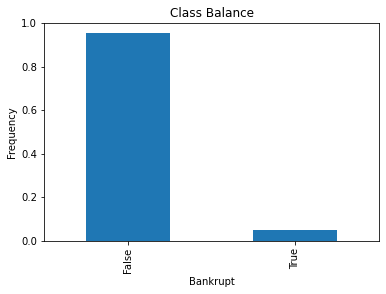

In [8]:
# Create a bar chart of the value counts for the "bankrupt" column & plot class balance
df["bankrupt"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Bankrupt",
    ylabel="Frequency",
    title="Class Balance"
);

It looks like most of the companies in my dataset are doing all right for themselves. However, it also shows us that I have an imbalanced dataset, where my majority class is far bigger than my minority class.

In the `Working with JSON files` project, I saw that there were 64 features of each company, each of which had some kind of numerical value. Since it might be useful to understand where the values for one of these features cluster, I'll make a boxplot to see how the values in `"feat_27"` are distributed.

**Feature Box Plot**

Here I'll be using seaborn to create a boxplot that shows the distributions of the `"feat_27"` column for both groups in the `"bankrupt"` column.

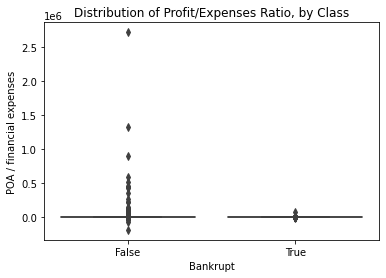

In [9]:
# Create boxplot
sns.boxplot(x="bankrupt", y="feat_27", data=df)
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Class");

This look a bit funny. Boxplots help us see the quartiles in a dataset, and this one doesn't really do that. So I'll check the distribution of `"feat_27"`to see if I can figure out what's going on here.

**Feature Summary Stats**

I'll use the `describe` method on the column for `"feat_27"`.

In [10]:
# Summary statistics for "feat_27"
df["feat_27"].describe()

count    9.312000e+03
mean     1.206467e+03
std      3.547726e+04
min     -1.901300e+05
25%      0.000000e+00
50%      1.064300e+00
75%      4.788275e+00
max      2.723000e+06
Name: feat_27, dtype: float64

In [11]:
df["feat_27"].describe().apply("{0:,.0f}".format)

count        9,312
mean         1,206
std         35,477
min       -190,130
25%              0
50%              1
75%              5
max      2,723,000
Name: feat_27, dtype: object

Note that the median is around 1, but the mean is over 1000. That suggests that this feature is skewed to the right. I'll now make a histogram to see what the distribution actually looks like.

**Feature Histogram**

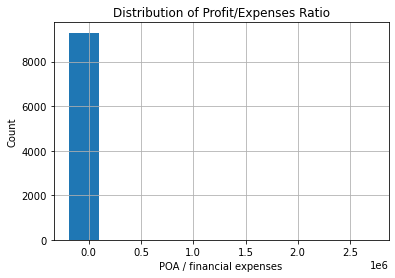

In [12]:
# Plot a histogram of "feat_27"
df["feat_27"].hist()
plt.xlabel("POA / financial expenses")   # Label x-axis "POA / financial expenses"
plt.ylabel("Count"),                     # Label y-axis "Count"
plt.title("Distribution of Profit/Expenses Ratio"); # Title "Distribution of Profit/Expenses Ratio"

I saw it in the numbers and now I see it in the histogram. The data is very skewed. So, in order to create a helpful boxplot, I need to trim the data. 

**Clipped Feature Histogram**

In [13]:
df["feat_27"].quantile([0.1, 0.9])

0.1    -2.00735
0.9    27.70170
Name: feat_27, dtype: float64

In [14]:
q1, q9 = df["feat_27"].quantile([0.1, 0.9])
mask = df["feat_27"].between(q1, q9)
mask.head

<bound method NDFrame.head of company_id
1         True
2        False
3         True
5        False
6         True
         ...  
10499    False
10500    False
10501    False
10502    False
10503     True
Name: feat_27, Length: 9977, dtype: bool>

I need to recreate the boxplot that I made above, this time only using the values for `"feat_27"` that fall between the `0.1` and `0.9` quantiles for the column.

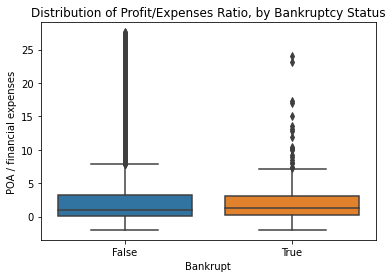

In [15]:
# Create clipped boxplot
q1, q9 = df["feat_27"].quantile([0.1, 0.9])
mask = df["feat_27"].between(q1, q9)
sns.boxplot(x="bankrupt", y="feat_27", data=df[mask])
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Bankruptcy Status");

That makes a lot more sense. I'll take a look at some of the other features in the dataset to see what else is out there.

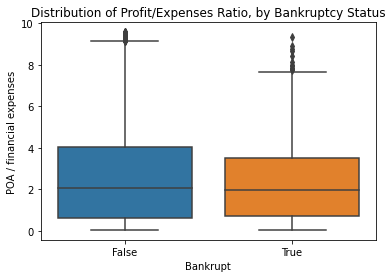

In [16]:
# Explore another feature
q1, q9 = df["feat_34"].quantile([0.1, 0.9])
mask = df["feat_34"].between(q1, q9)
sns.boxplot(x="bankrupt", y="feat_34", data=df[mask])
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Bankruptcy Status");

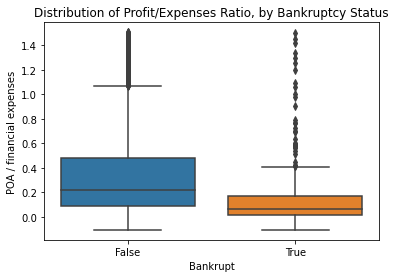

In [17]:
# Explore another feature
q1, q9 = df["feat_26"].quantile([0.1, 0.9])
mask = df["feat_26"].between(q1, q9)
sns.boxplot(x="bankrupt", y="feat_26", data=df[mask])
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Bankruptcy Status");

Looking at other features, I can see that they're skewed, too. This will be important to keep in mind when I decide what type of model I want to use.

Another important consideration for model selection is whether there are any issues with multicollinearity in my model.

**Correlation Heatmap**

I'll plot a correlation heatmap of features in `df`. Since `"bankrupt"` will be my target, I don't need to include it in my heatmap.

In [18]:
corr = df.drop(columns="bankrupt").corr()
corr.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
feat_1,1.000000,0.269458,-0.272459,0.001356,-0.001074,-0.218029,0.998734,0.002394,-0.056762,-0.269046,...,0.011807,0.008011,0.048601,-0.016755,-0.003589,0.002573,-0.041124,0.129884,0.009781,-0.002386
feat_2,0.269458,1.000000,-0.998303,-0.001396,-0.011338,-0.986583,0.267488,-0.002274,0.005119,-0.999678,...,-0.009207,-0.001792,-0.000553,0.000636,0.000857,0.001638,0.001421,0.388127,-0.010902,0.015879
feat_3,-0.272459,-0.998303,1.000000,0.002033,0.011153,0.985541,-0.270386,0.001442,-0.004605,0.998375,...,0.009951,0.001375,0.000392,-0.000271,-0.000553,0.006904,-0.002897,-0.387808,0.013798,0.037475
feat_4,0.001356,-0.001396,0.002033,1.000000,0.001296,-0.000033,0.001249,0.797207,-0.002760,0.001427,...,-0.000576,0.000495,0.000063,-0.002573,-0.000564,0.006970,-0.000543,-0.000346,0.017230,0.000077
feat_5,-0.001074,-0.011338,0.011153,0.001296,1.000000,0.010719,-0.000923,0.001339,-0.000417,0.011343,...,0.001234,-0.000201,-0.000005,0.000109,0.000138,0.000198,-0.000616,-0.005583,0.002288,0.000749


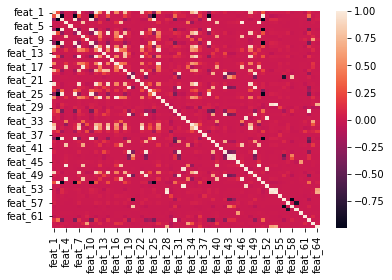

In [19]:
corr = df.drop(columns="bankrupt").corr()
sns.heatmap(corr);

So what did I learn from this EDA? First, my data is imbalanced. This is something I need to address in my data preparation. Second, many of my features have missing values that I'll need to impute. And since the features are highly skewed, the best imputation strategy is likely median, not mean. Finally, I have autocorrelation issues, which means that I should steer clear of linear models, and try a tree-based model instead.

## Split

So I'll start building that model.

In [20]:
# Create my feature matrix X and target vector y
target = "bankrupt"            # My target is "bankrupt"
feature = "feat_27"
X = df.drop(columns="bankrupt")
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


In order to make sure that my model can generalize, I need to put aside a test set that I'll use to evaluate my model once it's trained.

In [21]:
# Divide my data (X and y) into training and test sets using a randomized train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42             # My validation set should be 20% of my total data & set a random_state for reproducibility
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


Note that if I wanted to tune any hyperparameters for my model, I'd do another split here, further dividing the training set into training and validation sets. However, I'm going to leave hyperparameters for the next step, so no need to do the extra split now.

## Resample

Now that I've split my data into training and validation sets, I can address the class imbalance I saw during my EDA. One strategy is to resample the training data. I'll start with under-sampling.

**Under-Sampling**

In [22]:
# Create a new feature matrix X_train_under and target vector y_train_under by performing random under-sampling on my training data
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)
X_train_under.head()

(768, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.121400,0.097238,0.74500,8.66160,25.8370,0.000000,0.158840,9.284100,2.7588,0.902760,...,775.71,0.075999,0.13447,0.94243,0.000000,4.9049,11.3390,12.865,28.3720,17.4870
1,0.316280,0.264920,0.65346,3.46660,55.1890,0.290140,0.316280,2.774700,2.4721,0.735080,...,1367.90,0.119990,0.43027,0.87412,0.000000,10.6020,4.5533,39.115,9.3314,30.2870
2,0.066615,0.890270,-0.48007,0.46076,-76.3080,0.047487,0.087936,-0.011406,1.0952,-0.010155,...,-46566.00,0.086894,-6.56010,0.91311,0.000000,32.0280,10.0480,105.220,3.4689,5.2362
3,0.208000,0.363630,0.33875,1.93160,-5.3169,0.251870,0.258280,1.603300,1.0535,0.583020,...,187050.00,0.050746,0.35676,0.94925,0.000000,34.8840,19.0030,24.498,14.8990,18.2040
4,0.096863,0.299320,0.35393,2.42640,31.5630,0.267550,0.125130,2.341000,1.0495,0.700680,...,2993.00,0.047123,0.13824,0.95288,0.073041,13.7820,6.8621,39.668,9.2013,5.7376


And then I'll over-sample.

**Over-Sampling**

In [23]:
# Create a new feature matrix X_train_over and target vector y_train_over by performing random over-sampling on my training data
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)
X_train_over.head()

(15194, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.279320,0.053105,0.852030,17.0440,199.080,0.741770,0.353570,16.00600,1.2346,0.84997,...,52857.00,0.190040,0.328630,0.80996,0.00000,NaN,4.1858,11.002,33.1760,18.5720
1,0.001871,0.735120,0.156460,1.2269,-10.837,0.000000,0.002938,0.36032,1.4809,0.26488,...,440.02,0.014794,0.007064,0.99803,0.00000,7.4268,2.2925,169.960,2.1476,9.6185
2,0.113940,0.490250,0.077121,1.2332,-43.184,-0.000171,0.113940,1.03980,1.1649,0.50975,...,4617.40,0.214890,0.223520,0.78761,0.27412,6.2791,6.1622,103.630,3.5220,1.9673
3,0.008136,0.652610,0.148120,1.2628,29.071,0.000000,0.008136,0.53230,1.2891,0.34739,...,920.98,0.045169,0.023421,0.99434,0.14403,22.7480,2.2673,159.580,2.2872,4.4718
4,0.045396,0.279640,0.708730,3.7656,238.120,0.000000,0.056710,2.57610,1.0169,0.72036,...,10744.00,0.047501,0.063019,0.94624,0.00000,13.8860,49.0660,91.984,3.9681,29.0460


In [24]:
y_train_over.value_counts(normalize=True)

False    0.5
True     0.5
Name: bankrupt, dtype: float64

# Build Model

## Baseline

As always, I need to establish the baseline for my model. Since this is a classification problem, I'll use accuracy score.

**Baseline Accuracy**

In [25]:
# Calculate the baseline accuracy score for my model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9519


Note here that, because my classes are imbalanced, the baseline accuracy is very high. I should keep this in mind because, even if my trained model gets a high validation accuracy score, that doesn't mean it's actually *good.* 

## Iterate

Now that I have a baseline, I'll build a model to see if I can beat it.

**Build Models**

I'll create three identical models: `model_reg`, `model_under` and `model_over`. All of them should use a `SimpleImputer` followed by a `DecisionTreeClassifier`. Then I'll Train `model_reg` using the unaltered training data. For `model_under`, I'll use the undersampled data. For `model_over`, I'll use the oversampled data.

In [26]:
# Fit on `X_train`, `y_train`
model_reg = make_pipeline(
    SimpleImputer(strategy="median"),DecisionTreeClassifier(random_state=42)
)
model_reg.fit(X_train, y_train)

# Fit on `X_train_under`, `y_train_under`
model_under = make_pipeline(
    SimpleImputer(strategy="median"),DecisionTreeClassifier(random_state=42)
)
model_under.fit(X_train_under, y_train_under)

# Fit on `X_train_over`, `y_train_over`
model_over = make_pipeline(
    SimpleImputer(strategy="median"),DecisionTreeClassifier(random_state=42)
)
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

## Evaluate

**Evaluate Models**

In [27]:
# Calculate training and test accuracy for my three models
for m in [model_reg, model_under, model_over]:
    acc_train = m.score(X_train, y_train)
    acc_test = m.score(X_test, y_test)

    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9359
Training Accuracy: 0.7421
Test Accuracy: 0.7104
Training Accuracy: 1.0
Test Accuracy: 0.9344


As I mentioned earlier, "good" accuracy scores don't tell me much about the model's performance when dealing with imbalanced data. So instead of looking at what the model got right or wrong, I'll see how its predictions differ for the two classes in the dataset.

**Confusion Matrix**

I'll plot a confusion matrix that shows how my best model performs on my validation set.

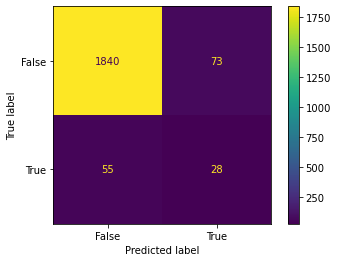

In [28]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_reg, X_test, y_test);

In this step, I didn't do any hyperparameter tuning, but it will be helpful in the next step to know what the depth of the tree `model_over`.

**Calculate Tree Depth**

In [29]:
# Determine the depth of the decision tree in model_over
depth = model_over.named_steps["decisiontreeclassifier"].get_depth()
print(depth)

33


# Communicate

Now that I have a reasonable model, I'll graph the importance of each feature.

**Feature Importances**

I'll create a horizontal bar chart with the 15 most important features for `model_over`.

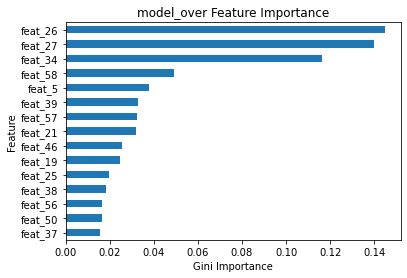

In [30]:
# Get importances
importances = model_over.named_steps["decisiontreeclassifier"].feature_importances_

# Put importances into a Series
feat_imp = pd.Series(importances, index=X_train_over.columns).sort_values()

# Plot series
feat_imp.tail(15).plot(kind="barh")
plt.xlabel("Gini Importance")              # Label x-axis "Gini Importance"
plt.ylabel("Feature")
plt.title("model_over Feature Importance");

There's my old friend `"feat_27"` near the top, along with features 34 and 26. It's time to share my findings.

**Save Model**

I'll save my best-performing model to a a file named `"model-5-2.pkl"` using a context manager.

In [31]:
# Save my model as `"model-5-2.pkl"`
with open("model-5-2.pkl", "wb") as f:
    pickle.dump(model_over, f)

**Load Model**

I want to make sure I've saved my model correctly by loading `"model-5-2.pkl"` and assigning to the variable `loaded_model`.

In [32]:
# Load `"model-5-2.pkl"`
with open("model-5-2.pkl", "rb") as f:
    loaded_model = pickle.load(f)
print(loaded_model)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])
